In [2]:
### Imports
import sys
sys.path.insert(0, '/home/augustsemrau/drive/M1semester/02506_AdvancedImageAnalysis/02505miniproject')

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init

from PIL import Image

# from data_utils import EM_DATA
from src.model.U_NET_model import UNet
from src.model.model_train import train_model
from src.features.image_augmentation import elastic, add_noise, shear, rotate, zoom

import skimage.io
import glob 
import os
import cv2

def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'U_NET_model'

# U-Net training notebook

## Load Data

In [31]:
# Make dataset class.
class Dataset(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, train, val=False, augmentation_count=None):
        self._train = train
        self.augmentation_count = augmentation_count
        self._transform = transforms.Compose([transforms.ToTensor()])

        if self._train:
            image_dir = "Data/train_images"
            label_dir = "Data/train_labels"
        else:
            image_dir = "Data/test_images"

        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.png"))) if self._train else None

        self.images = []
        self.labels = []
        
        if train and not val:
            r = range(5,len(self.image_paths))
        elif train and val:
            r = range(0,5)
        else:
            r = range(len(self.image_paths))

        for idx in r:
            image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)/255
            self.images.append(torch.tensor(image).unsqueeze(0))#, dtype=torch.float64).unsqueeze(0))
            if self._train:
                label = np.asarray(Image.open(self.label_paths[idx])).copy()
                label[label>0] = 255/255
                self.labels.append(torch.tensor(label).unsqueeze(0))#, dtype=torch.float64).unsqueeze(0))
            else:
                self.labels.append(torch.zeros([512,512]).unsqueeze(0))#, dtype=torch.float64).unsqueeze(0))

        

        if self.augmentation_count is not None and train:
            for idx in r:
                for aug in range(augmentation_count):
                    func = np.random.choice([rotate])#add_noise, shear, zoom])#,elastic])
                    image, label = func(self.images[idx].squeeze(0), self.labels[idx].squeeze(0))

                    # Apply the transformations defined in the input transform parameter. Remember to end it with 'to_tensor'
                    self.images.append(torch.tensor(self._transform(image)))#, dtype=torch.float64))
                    self.labels.append(torch.tensor(self._transform(label)))#, dtype=torch.float64))


    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.images)


train_dataset = Dataset(train=True, augmentation_count=2)
val_dataset = Dataset(train=True, val=True)
test_dataset = Dataset(train=False)
# train_dataset[44][1].shape
# test_dataset[0][0]

<ipython-input-31-cf2cbe6d1181>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images.append(torch.tensor(self._transform(image)))#, dtype=torch.float64))
<ipython-input-31-cf2cbe6d1181>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels.append(torch.tensor(self._transform(label)))#, dtype=torch.float64))


In [32]:
train_dataset.__len__()
# val_dataset.__len__()
# test_dataset.__len__()

75

torch.Size([1, 512, 512])


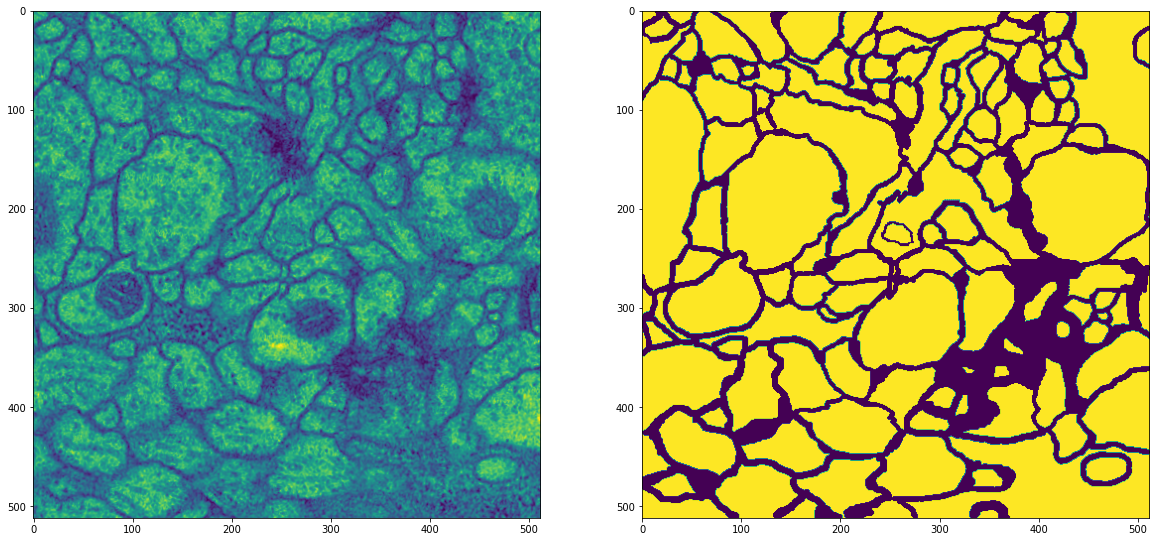

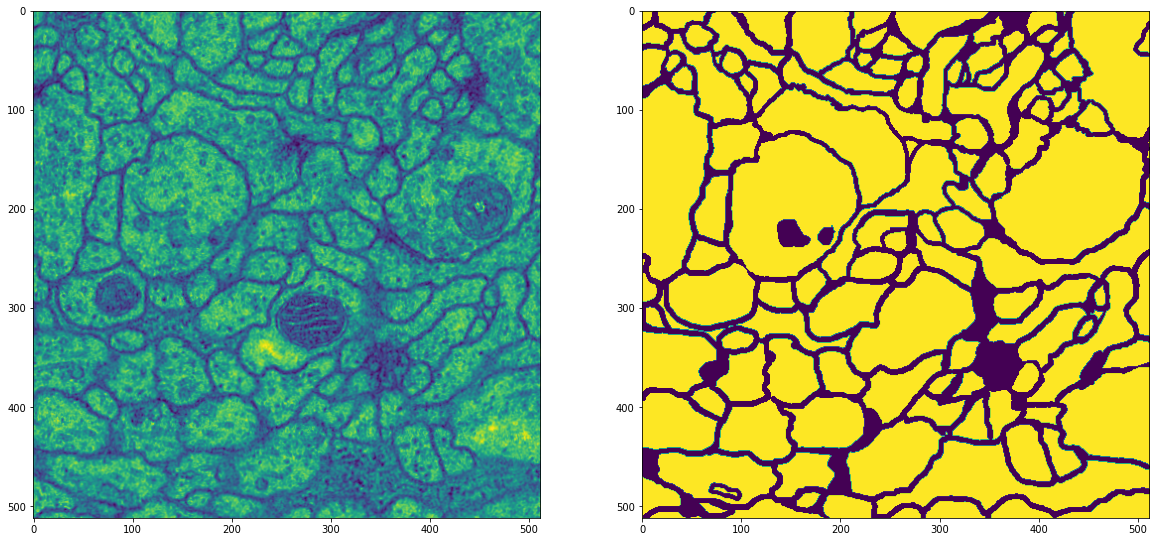

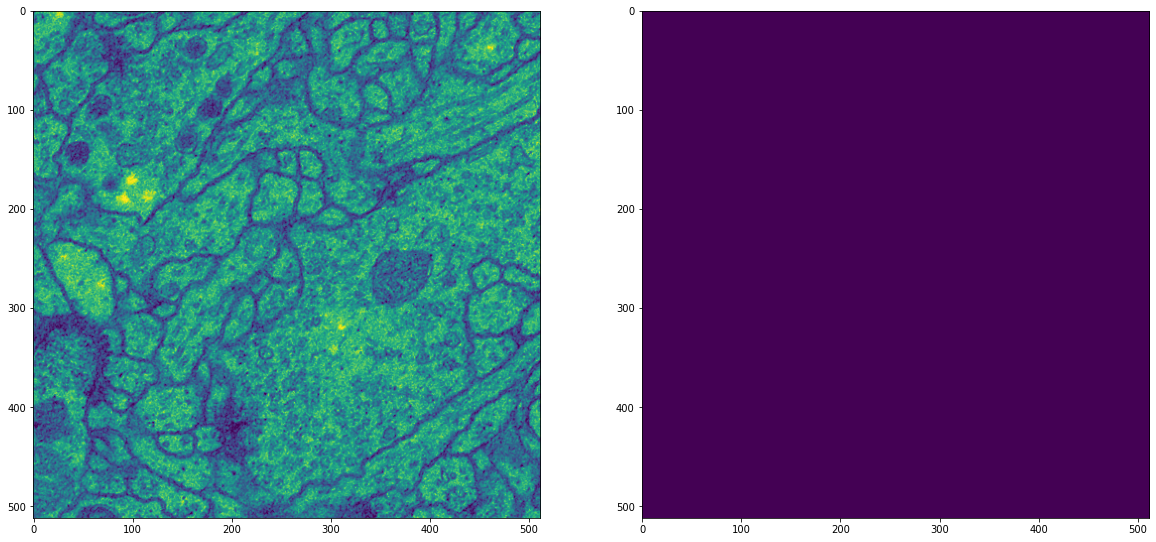

In [33]:
## Show some images from train, val and test sets

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = train_dataset[0]
print(data_ex[0].shape)
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# data_ex = train_dataset[25]
# print(data_ex[0].shape)
# ax[0].imshow(data_ex[0].numpy()[0,:,:])
# ax[1].imshow(data_ex[1].numpy()[0,:,:])
# plt.show()

# fig, ax = plt.subplots(1, 2, figsize=(20,10))
# data_ex = train_dataset[25+1]
# print(data_ex[0].shape)
# ax[0].imshow(data_ex[0].numpy()[0,:,:])
# ax[1].imshow(data_ex[1].numpy()[0,:,:])
# plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = val_dataset[3]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(20,10))
data_ex = test_dataset[4]
ax[0].imshow(data_ex[0].numpy()[0,:,:])
ax[1].imshow(data_ex[1].numpy()[0,:,:])
plt.show()


# Initialize and train U-Net
## First setup U-net

In [6]:
train_dataset[2][1]

tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], dtype=torch.float64)

In [7]:
## First we init the U-net

# Depth describes levels of unet - default is 5
model = UNet(1, in_channels=1, depth=1, merge_mode='concat')

set_seed(42)

# Test it works
x = Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
print(x)
out = model(x)
loss = torch.sum(out)
loss.backward()

print("Model parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([[[[0.3745, 0.9507, 0.7320,  ..., 0.7257, 0.6134, 0.4182],
          [0.9327, 0.8661, 0.0452,  ..., 0.2973, 0.9244, 0.9711],
          [0.9443, 0.4742, 0.8620,  ..., 0.2726, 0.4135, 0.1219],
          ...,
          [0.2908, 0.5167, 0.7222,  ..., 0.3578, 0.9747, 0.1724],
          [0.5067, 0.9408, 0.0381,  ..., 0.0352, 0.6746, 0.6631],
          [0.6024, 0.7291, 0.7291,  ..., 0.5242, 0.0067, 0.2575]]]])
Model parameters:  37633


## Init optimizer and loss

In [8]:
learning_rate = 0.8e-3
# learning_rate = 3e-4
weight_decay = 4e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        """
        Returns 1.0 - Dice coefficient = loss
        """
        assert y_pred.size() == y_true.size()
        
        ## Convert to 1D vector
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        
        ## Find intersection
        intersection = (y_pred * y_true).sum()
        
        ## Compute Dice coefficient
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth)
        return 1. - dsc

## Training

In [9]:
model, training_loss, validation_loss, global_steps = train_model(model=model, 
                                                                optimizer=optimizer, 
                                                                num_epochs=25, 
                                                                train_dataset=train_dataset, 
                                                                val_dataset=val_dataset, 
                                                                CUDA=False, 
                                                                SAVE_CHECKPOINTS=False)

Epoch 1/25
----------


100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Traning loss: 11.49684297461998
Validation loss 1.9624210865083578
Epoch 2/25
----------


100%|██████████| 75/75 [00:47<00:00,  1.57it/s]


Traning loss: 9.139170871119095
Validation loss 0.6895508585454642
Epoch 3/25
----------


100%|██████████| 75/75 [00:52<00:00,  1.42it/s]


Traning loss: 9.114919796191643
Validation loss 0.6884498092072331
Epoch 4/25
----------


100%|██████████| 75/75 [00:51<00:00,  1.46it/s]


Traning loss: 9.108746385350543
Validation loss 0.6877460298484496
Epoch 5/25
----------


100%|██████████| 75/75 [00:47<00:00,  1.58it/s]


Traning loss: 9.106828616245325
Validation loss 0.6875923906820074
Epoch 6/25
----------


100%|██████████| 75/75 [00:45<00:00,  1.66it/s]


Traning loss: 9.106099459578477
Validation loss 0.6875505134798399
Epoch 7/25
----------


100%|██████████| 75/75 [00:46<00:00,  1.62it/s]


Traning loss: 9.105859436354626
Validation loss 0.6875501153566119
Epoch 8/25
----------


100%|██████████| 75/75 [00:43<00:00,  1.72it/s]


Traning loss: 9.105840725757625
Validation loss 0.6875665861619898
Epoch 9/25
----------


100%|██████████| 75/75 [00:40<00:00,  1.84it/s]


In [36]:
for inputs, targets in val_dataset:
    print(inputs.unsqueeze(0).dtype)
    # print(targets.shape)

torch.float64
torch.float64
torch.float64
torch.float64
torch.float64


torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])
torch.Size([3, 516, 1544])


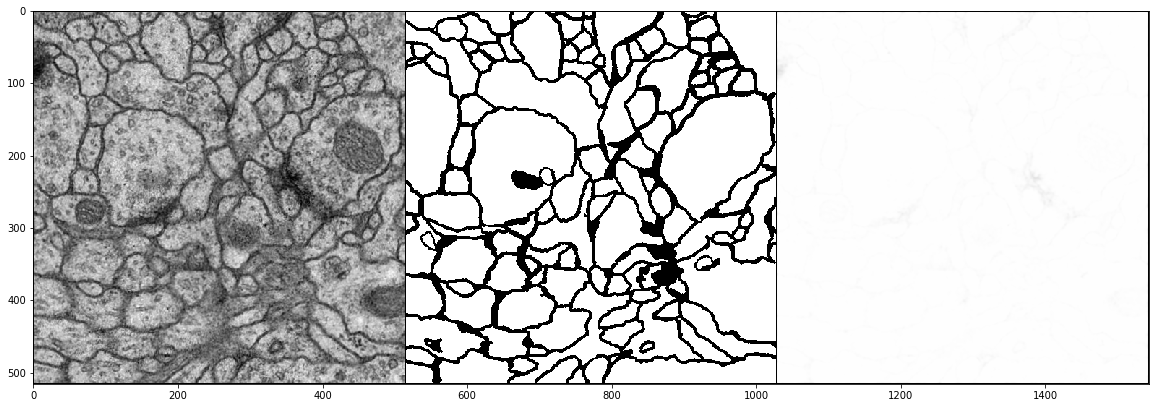

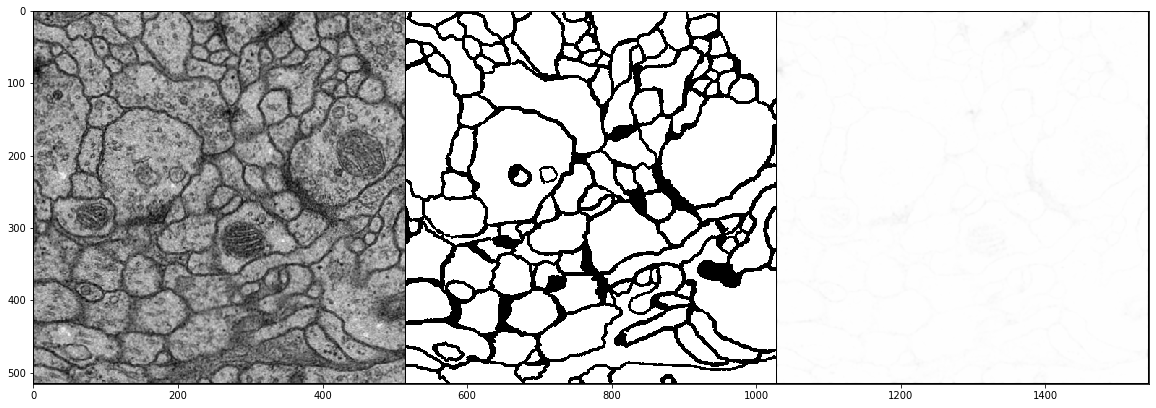

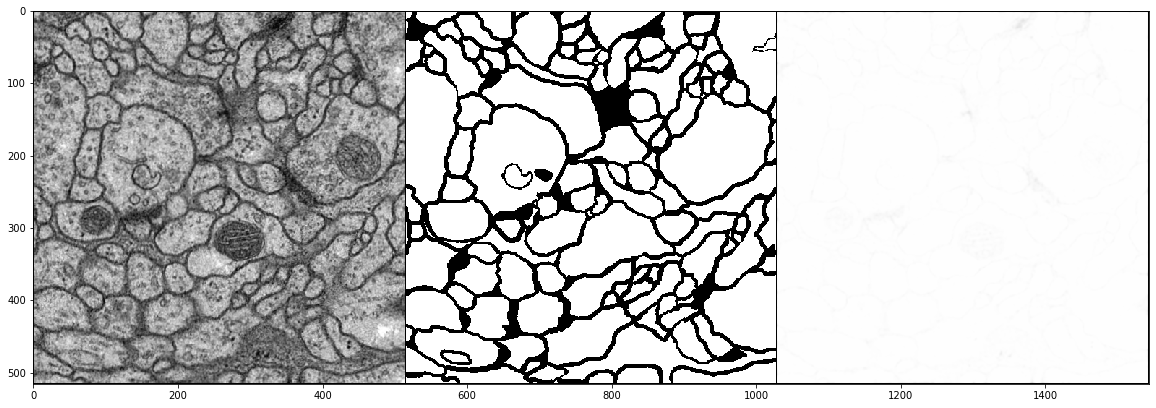

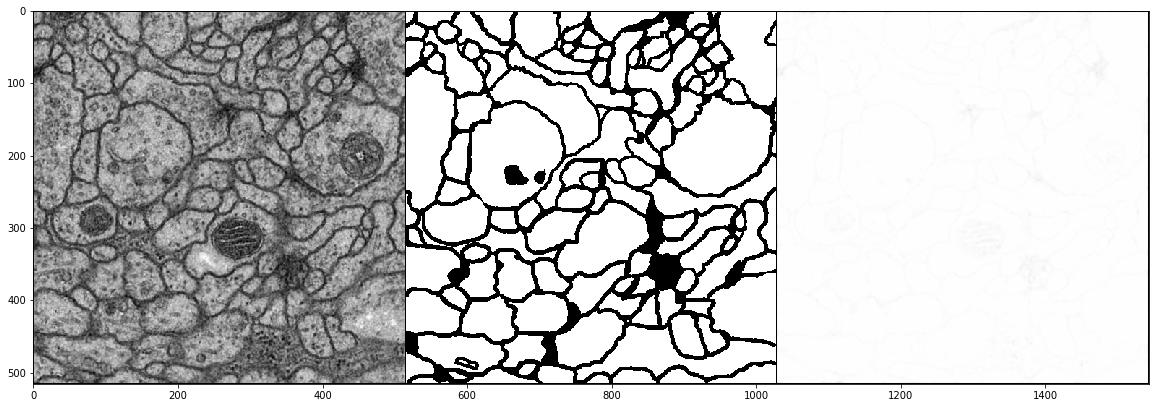

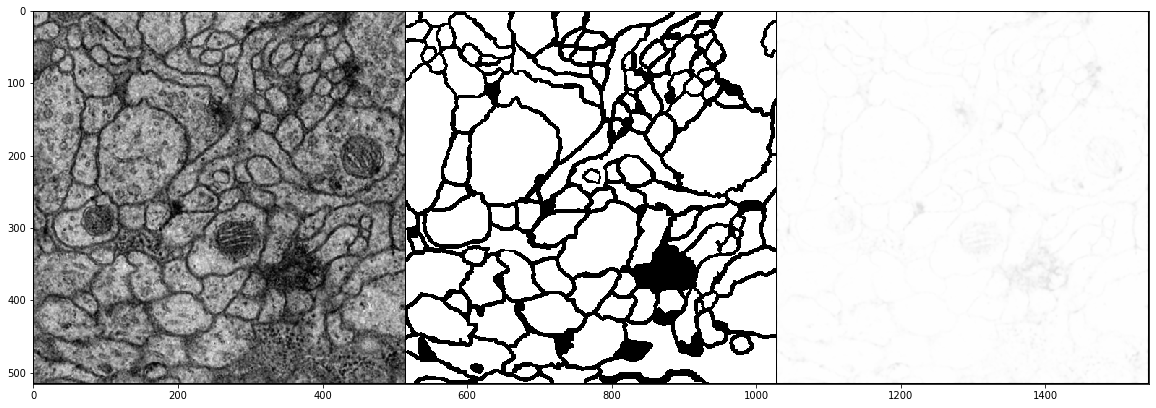

In [39]:
for inputs, targets in val_dataset:
    x = torch.autograd.Variable(torch.FloatTensor(np.random.random((1, 1, 512, 512))))
    inputs=inputs.unsqueeze(0)
    inputs = inputs.float()
    targets=targets.unsqueeze(0)
    y_hat = model(inputs)
    # print(targets.shape)
    # print(y_hat.shape)
    npgrid = torchvision.utils.make_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0))
    print(npgrid.shape)
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

In [ ]:
np.transpose(npgrid, (1, 2, 0)).shape

torch.Size([516, 1544, 3])

# Extra

In [ ]:
# def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
#     """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

#     grid = torchvision.utils.make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
#     npgrid = grid.cpu().numpy()

#     plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

#     ax = plt.gca()
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)

#     if not (title == ''):
#         plt.title(title)

#     plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)
#     plt.clf()

# # Example usage
# plot_images_grid(torch.cat([inputs.cpu(), targets.cpu(), y_hat.cpu()], dim=0), 'test.png')